## 读取trainall,获取文本编码

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import pickle
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
with open('Trainall.pkl', 'rb') as f:
    encoded_df = pickle.load(f)
df=encoded_df

grouped = df.groupby('Company Number')

# 定义一个函数，用于对每个组进行处理
def process_group(group):
    # 提取“Encoded Texts”列的值，并将其放入一个列表中
    texts = group['Encoded Texts'].values.tolist()
    # 如果列表的长度超过changdu，则将其截断为长度为changdu的列表。
    changdu = 10
    if len(texts) > changdu:
        texts = texts[:changdu]
    # 如果长度不足30，则使用前一个向量进行填充，直到列表长度为30。
    elif len(texts) < changdu:
        padding = [texts[-1] for _ in range(changdu - len(texts))]
        texts = padding + texts

    # 将每个公司的30个Encoded Texts列表反转。
    texts = np.array(texts[::-1])

    # 返回处理后的结果
    return texts

# 对每个分组应用process_group函数，并将结果合并为一个新的DataFrame
new_df = pd.DataFrame({'Company Number': grouped.groups.keys(), 'Encoded Texts Array': grouped.apply(process_group).values})

# 查看结果
print(new_df.head())

   Company Number                                Encoded Texts Array
0               0  [[0.26694655, 0.9597109, -0.80210227, -0.28551...
1               1  [[-0.95734376, 0.21193711, -1.3041018, -0.5629...
2               2  [[-0.92577845, 0.2726554, -1.2605135, -0.48989...
3               3  [[-0.63378906, 0.4488125, -0.8418375, 0.004676...
4               4  [[0.09655304, 0.2915736, -0.012331143, 0.01824...


In [3]:
print(np.array(new_df["Encoded Texts Array"][0]).shape)  #每个公司对应文本的向量化
print(len(encoded_df))  #编码评论数
print(len(new_df))  #公司数目

(10, 768)
270331
7236


In [4]:
X_te=np.array(new_df["Encoded Texts Array"])
X_te_tensors = [torch.from_numpy(x) for x in X_te]
X_te_tensor = torch.stack(X_te_tensors, dim=0)

In [5]:
print(X_te_tensor.shape)

torch.Size([7236, 10, 768])


## 读取公司特征数据

In [6]:
df_a = pd.read_csv(r"D:\桌面\大数据竞赛\训练集竞赛2\cwtz_train.csv")
X_numerical = df_a.iloc[:, 1:-1].values
y = df_a.iloc[:, -1].values

In [7]:
print(X_numerical.shape)
print(y.shape)

(7236, 52)
(7236,)


## 选取样本准备训练

In [8]:
scaler = StandardScaler()
X_numerical= scaler.fit_transform(X_numerical)

In [9]:
# 划分训练集和测试集
X_text_train, X_text_test, X_numerical_train, X_numerical_test, y_train, y_test = train_test_split(
    X_te_tensor, X_numerical, y, test_size=0.2, random_state=0)

In [10]:
# 将数据转换为PyTorch张量
#X_text_train = torch.tensor(X_text_train)
#X_text_test = torch.tensor(X_text_test)
X_numerical_train = torch.tensor(X_numerical_train, dtype=torch.float32)
X_numerical_test = torch.tensor(X_numerical_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# 将数据封装成TensorDataset
train_dataset = TensorDataset(X_text_train, X_numerical_train, y_train)
test_dataset = TensorDataset(X_text_test, X_numerical_test, y_test)

In [11]:
# 定义批量大小和数据加载器
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [13]:
# 定义模型
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        # self.embedding_matrix = nn.Parameter(torch.randn(64, 1))
        #self.text_embedding = nn.Embedding(num_embeddings=116, embedding_dim=100)
        self.text_rnn = nn.LSTM(input_size=768, hidden_size=52, batch_first=True)
        self.linear0 = nn.Linear(in_features=768*2, out_features=52)
        self.linear1 = nn.Linear(in_features=52+52, out_features=500)
        self.linear2 = nn.Linear(in_features=500, out_features=100)
        self.linear3 = nn.Linear(in_features=100, out_features=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, numerical):
        # text=text.to(torch.float)
        # text=self.relu(self.linear0(text))
        # numerical = numerical.to(torch.float)
        # text=text.to(torch.float)
        text,_=self.text_rnn(text)
        text = text[:,-1,:]
        # text=torch.cat([text[:,-1,:],text[:,-2,:]],dim=1)
        # text=self.relu(self.linear0(text))
        x = torch.cat([text, numerical], dim=1)
        x=x.to(torch.float)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.sigmoid(self.linear3(x))
        return x
# 将模型移动到GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [14]:
# 训练模型
num_epochs = 3

train_losses = []
test_losses = []
test_auc_scores = []
for epoch in range(num_epochs):
    # 训练模型
    train_loss = 0.0
    model.train()
    for i, batch in enumerate(train_dataloader):
        text, numerical, label = batch
        text = text.to(device)
        numerical = numerical.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(text, numerical)
        loss = criterion(output.squeeze(), label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(batch)
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)

    # 测试模型
    test_loss = 0.0
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        for batch in test_dataloader:
            text, numerical, label = batch
            text = text.to(device)
            numerical = numerical.to(device)
            label = label.to(device)
            output = model(text, numerical)
            loss = criterion(output.squeeze(), label)
            test_loss += loss.item() * len(batch)
            predictions.append(output.cpu().numpy())
            targets.append(label.cpu().numpy())
    test_loss /= len(test_dataset)
    test_losses.append(test_loss)
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    test_auc_score = roc_auc_score(targets, predictions)
    test_auc_scores.append(test_auc_score)

    print(f"Epoch {epoch + 1:02d}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Test AUC: {test_auc_score:.4f}")

Epoch 01, Train Loss: 0.0190, Test Loss: 0.0101, Test AUC: 0.8126
Epoch 02, Train Loss: 0.0145, Test Loss: 0.0108, Test AUC: 0.8139
Epoch 03, Train Loss: 0.0140, Test Loss: 0.0109, Test AUC: 0.8158


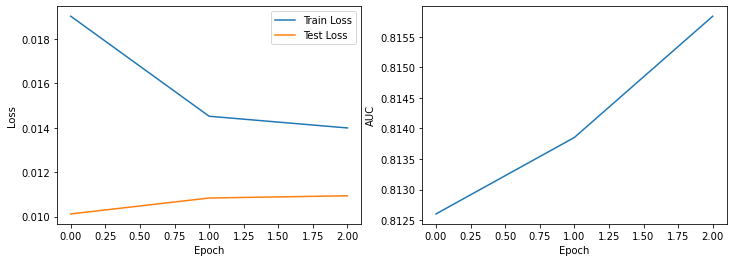

In [15]:
# 绘制 loss 和 AUC 曲线
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(train_losses, label="Train Loss")
ax[0].plot(test_losses, label="Test Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()
ax[1].plot(test_auc_scores)
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("AUC")
plt.show()

In [16]:
with open('Testall.pkl', 'rb') as f:
    encoded_df = pickle.load(f)
df = encoded_df

grouped = df.groupby('Company Number')

# 定义一个函数，用于对每个组进行处理
def process_group(group):
    # 提取“Encoded Texts”列的值，并将其放入一个列表中
    texts = group['Encoded Texts'].values.tolist()
    # 如果列表的长度超过30，则将其截断为长度为30的列表。
    changdu = 10
    if len(texts) > changdu:
        texts = texts[:changdu]
    # 如果长度不足30，则使用前一个向量进行填充，直到列表长度为30。
    elif len(texts) < changdu:
        padding = [texts[-1] for _ in range(changdu - len(texts))]
        texts = padding + texts

    # 将每个公司的30个Encoded Texts列表反转。
    texts = np.array(texts[::-1])

    # 返回处理后的结果
    return texts

# 对每个分组应用process_group函数，并将结果合并为一个新的DataFrame
new_df = pd.DataFrame({'Company Number': grouped.groups.keys(), 'Encoded Texts Array': grouped.apply(process_group).values})

# 查看结果
print(new_df.head())

   Company Number                                Encoded Texts Array
0              12  [[-0.4314325, 0.70720446, -0.9864973, -0.29588...
1              13  [[-0.23587735, 0.8444132, -0.8237666, -0.05725...
2              14  [[-0.60591453, 0.4509466, -1.0440749, -0.27577...
3              19  [[-0.09272678, 0.99364465, -0.56586164, 0.4142...
4              23  [[0.16473942, 0.22861679, -0.65105367, 0.03080...


In [17]:
X_te=np.array(new_df["Encoded Texts Array"])
X_te_tensors = [torch.from_numpy(x) for x in X_te]
X_te_tensor = torch.stack(X_te_tensors, dim=0)

In [18]:
df_test= pd.read_csv(r"D:\桌面\cwtz_test.csv")
# 将文本特征和数字特征分离
X_numerical_test = df_test.iloc[:, 1:].values

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\桌面\\cwtz_test.csv'

In [ ]:
print(type(X_numerical_test),X_numerical_test.shape)
print(type(X_te_tensor),X_te_tensor.shape)

In [ ]:
# 对数字特征进行标准化处理
scaler = StandardScaler()
X_numerical_test = scaler.fit_transform(X_numerical_test)

In [ ]:
# # 将预处理后的数据转换为PyTorch张量
X_numerical_test = torch.tensor(X_numerical_test, dtype=torch.float32)

# # 将数据封装成TensorDataset
test_dataset = TensorDataset(X_te_tensor, X_numerical_test)

# 定义批量大小和数据加载器
batch_size = 32
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# 使用训练好的模型进行预测
predictions = []
model.eval()  # 切换为评估模式
with torch.no_grad():  # 禁用梯度计算，加速推理过程
    for batch in test_dataloader:
        text, numerical = batch
        text = text.to(device)
        numerical = numerical.to(device)
        output = model(text, numerical)
        predictions.extend(output.cpu().numpy().tolist())

In [ ]:
# 输出预测结果
jieguo=[]
jieguo=[x[0] for x in predictions ]
df_test['预测结果'] = jieguo
df_test.to_excel(r"D:\桌面\竞赛二结果第三次.xlsx", index=False)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(jieguo)

In [ ]:
sum(np.array(jieguo)>0.5)

In [ ]:
er=pd.read_csv(r"D:\桌面\第五组二结果第二次.csv")

In [ ]:
aaa =er["预测结果"]

In [ ]:
plt.plot(aaa)